# Choosing the Best Plan?

You work as an analyst for the telecommunications operator Megaline. The company offers its customers two prepaid plans: Surf and Ultimate. The marketing department wants to know which plan generates more revenue in order to adjust the advertising budget accordingly.

You will conduct a preliminary analysis of the plans based on a relatively small selection of customers. You’ll have data from 500 Megaline customers, including who they are, where they’re from, which plan they use, as well as the number of calls they made and text messages they sent in 2018.
Your task is to analyze customer behavior and determine which prepaid plan generates the most revenue.

For this project, which consists of several datasets, my approach to the analysis will be as follows:

- Load the necessary libraries and then load the various files for subsequent visualization.
- Perform a general overview of the data types contained in each dataset and check how many non-null entries exist per dataset.
- In case of discrepancies (such as missing, invalid, or duplicate data), proceed with data cleaning to prepare for further analysis.

# 1. Initialization

In [1]:
# Load libraries
import pandas as pd
import numpy as np
from scipy import stats as st
from math import factorial
import seaborn as sns
from matplotlib import pyplot as plt

In [ ]:
# Load dataframes
df_users = pd.read_csv('megaline_users.csv')
df_calls = pd.read_csv('megaline_calls.csv')
df_messages = pd.read_csv('megaline_messages.csv')
df_internet = pd.read_csv('megaline_internet.csv')
df_plans = pd.read_csv('megaline_plans.csv')

## 1.1 Plans

In [3]:
# Print general/summary information about the Plans DataFrame
df_plans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 260.0+ bytes


In [4]:
# Print a sample of the data
print(df_plans.head())

   messages_included  mb_per_month_included  minutes_included  \
0                 50                  15360               500   
1               1000                  30720              3000   

   usd_monthly_pay  usd_per_gb  usd_per_message  usd_per_minute plan_name  
0               20          10             0.03            0.03      surf  
1               70           7             0.01            0.01  ultimate  


### Fixing the Data

At this point, from what I can see, for the 2 rows and 8 columns, the data appears to be complete (no missing values).
Regarding duplicate data, I also don’t see any — only the detail that the "plan_name" column appears at the end of the dataset.
I consider it important for this column to be the first one (since the following columns depend on it).
There’s also a small discrepancy to address. <br>
<br>
At this point, by using .info(), I noticed that the data is in the correct format, and there are no duplicate or null values.
Analyzing the columns in the "plans" dataset, I only noticed that the "plan_name" column is located in position (-1),
so I proceeded to move it to position (0).

In [5]:
# Reorder the "plan_name" column to the beginning of the dataset
col = df_plans.pop('plan_name')
df_plans.insert(0, "plan_name", col)

### 1.1.1 Enrich the Data
There is a discrepancy between the number of MB included per month and the charge per GB (they are not standardized).

In [6]:
# Add column "gb_per_month_included" to standardize the included data and the extra data cost
df_plans['gb_per_month_included'] = df_plans['mb_per_month_included'] / 1024
df_plans['gb_per_month_included'] = df_plans['gb_per_month_included'].astype(int)

# Remove column "mb_per_month_included"
del df_plans["mb_per_month_included"]

# Print a sample of the data for the plans
col_gb = df_plans.pop("gb_per_month_included")
df_plans.insert(1, "gb_per_month_included", col_gb)
print(df_plans.head())

  plan_name  gb_per_month_included  messages_included  minutes_included  \
0      surf                     15                 50               500   
1  ultimate                     30               1000              3000   

   usd_monthly_pay  usd_per_gb  usd_per_message  usd_per_minute  
0               20          10             0.03            0.03  
1               70           7             0.01            0.01  


## 1.2 Users

In [7]:
# Print general/summary information about the Users DataFrame
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [8]:
# Print a sample of the data
# print(df_users.head())
# print()
print(df_users.sample(10))

     user_id first_name last_name  age  \
308     1308     Samara    Monroe   46   
289     1289      Steve     Blair   47   
241     1241       Lala     Walls   24   
427     1427      Zofia     Brock   64   
20      1020      Rutha      Bell   56   
203     1203      Manie    Grimes   50   
153     1153  Kathaleen  Crawford   30   
117     1117       Hank    Taylor   49   
234     1234       Matt    Taylor   19   
385     1385     Nohemi  Erickson   52   

                                                 city    reg_date      plan  \
308    Virginia Beach-Norfolk-Newport News, VA-NC MSA  2018-11-22      surf   
289                   Detroit-Warren-Dearborn, MI MSA  2018-11-12  ultimate   
241                                  Richmond, VA MSA  2018-08-27      surf   
427  Washington-Arlington-Alexandria, DC-VA-MD-WV MSA  2018-01-26  ultimate   
20                Dallas-Fort Worth-Arlington, TX MSA  2018-11-08      surf   
203                Boston-Cambridge-Newton, MA-NH MSA  2018-02-

Using .info(), I can observe a few things:
First, the data type stored in each column. The columns "reg_date" and "churn_date" are currently of type (object) but should be of type (datetime).
In addition, there are missing values in the "churn_date" column.

### 1.2.1 Fixing the Data

After reviewing the missing values in the "churn_date" column, we can conclude that this happens because users with an empty value in that column are active members.
It’s also important to check that the "user_id" values are unique, since there shouldn’t be any duplicates in that column.

In [9]:
# Correct the data type of the "reg_date" and "churn_date" columns to datetime
df_users['reg_date'] = pd.to_datetime(df_users['reg_date'])
df_users['churn_date'] = pd.to_datetime(df_users['churn_date'])

# Rename the "plan" column to match the "plan_name" column in the 'plans' dataset
df_users.rename(columns={"plan": "plan_name"}, inplace=True)

# Check for duplicate data
print("Duplicate IDs: ", df_users['user_id'].duplicated().sum())
print()

# Check the number of active and inactive users based on the values in the "churn_date" column
print("Active users:", df_users['churn_date'].isnull().sum())
print("Users who canceled:", df_users['churn_date'].notnull().sum())
print()

df_users.info()

Duplicate IDs:  0

Active users: 466
Users who canceled: 34

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   first_name  500 non-null    object        
 2   last_name   500 non-null    object        
 3   age         500 non-null    int64         
 4   city        500 non-null    object        
 5   reg_date    500 non-null    datetime64[ns]
 6   plan_name   500 non-null    object        
 7   churn_date  34 non-null     datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


### 1.2.2 Enrich the Data

At this point, we can observe that the number of active users (based on null and non-null values) is 466, <br>
while the number of users who canceled their subscription is 34. <br>
Since it’s important not to modify the null and non-null values in the "churn_date" column, <br>
I proceeded to add a new column that takes those values as a reference. <br>
Additionally, the data types for the columns "reg_date" and "churn_date" were modified.

In [10]:
# Add a column that identifies whether there is a null or non-null value in the "churn_date" column
df_users["user_active"] = np.where(df_users["churn_date"].isna(), "active", "no active")

print(df_users.sample(5))
print()
df_users.info()

     user_id first_name  last_name  age  \
175     1175     Shiloh   Stafford   25   
25      1025       Jess  Wilkinson   64   
416     1416       Deja       Moss   25   
447     1447      Ramon     Hester   62   
328     1328    Tamesha      Huber   20   

                                            city   reg_date plan_name  \
175    New York-Newark-Jersey City, NY-NJ-PA MSA 2018-09-30      surf   
25         Atlanta-Sandy Springs-Roswell, GA MSA 2018-10-28  ultimate   
416  Minneapolis-St. Paul-Bloomington, MN-WI MSA 2018-10-03      surf   
447            Orlando-Kissimmee-Sanford, FL MSA 2018-05-01      surf   
328  Minneapolis-St. Paul-Bloomington, MN-WI MSA 2018-02-10      surf   

    churn_date user_active  
175        NaT      active  
25         NaT      active  
416 2018-11-21   no active  
447        NaT      active  
328        NaT      active  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column       Non-N

## 1.3 Calls

In [11]:
# Print general/summary information about the Calls DataFrame
df_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


In [12]:
# Print a sample of data for the calls
# print(df_calls.head(10))
# print()
print(df_calls.sample(10))

              id  user_id   call_date  duration
98959   1354_491     1354  2018-09-12      0.24
86064    1317_90     1317  2018-11-15      0.00
24439   1093_362     1093  2018-12-28     10.28
86246   1318_101     1318  2018-10-25      9.92
15368   1061_310     1061  2018-12-24      0.80
19615   1074_129     1074  2018-12-27      4.92
132950  1479_467     1479  2018-12-08      7.38
18697   1071_566     1071  2018-07-18      9.34
32963   1123_321     1123  2018-11-21      3.41
108539  1383_119     1383  2018-12-17      5.98


At first glance, by printing the data types and sampling the dataset, I notice that the "id" column is stored as an object, <br>
and the "call_date" column also appears as an object — when it should actually be of type datetime.

### 1.3.1 Fixing the Data

At this stage, based on the previous observations, we proceed to check whether there are any missing or duplicate values,
since the "id" column should not contain any duplicates

In [13]:
print("Duplicated IDs: ", df_calls['id'].duplicated().sum())
print("Null IDs: ", df_calls['id'].isnull().sum())
print()

df_calls['call_date'] = pd.to_datetime(df_calls['call_date'])
df_calls.info()

Duplicated IDs:  0
Null IDs:  0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         137735 non-null  object        
 1   user_id    137735 non-null  int64         
 2   call_date  137735 non-null  datetime64[ns]
 3   duration   137735 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.2+ MB


### 1.3.2 Enrich the Data

According to the instructions, since Megaline rounds call durations from seconds to minutes, <br>
it’s necessary to round the values in the "duration" column so that all of them are expressed in minutes. <br>
Also, since the data will later be analyzed by month, a new column is created by extracting the month from the "call_date" column.

In [14]:
# Round call duration (from seconds to minutes) and convert the data type to int
df_calls['duration'] = np.ceil(df_calls['duration']).astype(int)
df_calls['month'] = df_calls['call_date'].dt.month

print(df_calls.head(10))

         id  user_id  call_date  duration  month
0   1000_93     1000 2018-12-27         9     12
1  1000_145     1000 2018-12-27        14     12
2  1000_247     1000 2018-12-27        15     12
3  1000_309     1000 2018-12-28         6     12
4  1000_380     1000 2018-12-30         5     12
5  1000_388     1000 2018-12-31         3     12
6  1000_510     1000 2018-12-27         6     12
7  1000_521     1000 2018-12-28        15     12
8  1000_530     1000 2018-12-28         6     12
9  1000_544     1000 2018-12-26         5     12


## 1.4 Messages

In [15]:
# Print general/summary information about the Messages DataFrame
df_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [16]:
# Print a sample of data for the messages
# print(df_messages.head(10))
# print()
print(df_messages.sample(10))

             id  user_id message_date
58187   1366_63     1366   2018-12-29
46475  1316_365     1316   2018-09-29
65755   1424_68     1424   2018-11-28
42452  1278_143     1278   2018-12-12
67633   1439_27     1439   2018-09-14
5014    1046_76     1046   2018-10-29
51024  1331_199     1331   2018-09-14
5578    1053_34     1053   2018-12-18
18946   1123_15     1123   2018-08-10
20746   1131_85     1131   2018-09-17


For the case of df_messages, by printing the data types and checking for null values, <br>
it can be observed that the data type of the "message_date" column appears as an object.

### 1.4.1 Fixing the Data

In [17]:
# Check for duplicate data in the "id" column
print("Duplicate IDs: ", df_messages['id'].duplicated().sum())
print("Null IDs: ", df_messages['id'].isnull().sum())
print()

df_messages['message_date'] = pd.to_datetime(df_messages['message_date'])
df_messages.info()

Duplicate IDs:  0
Null IDs:  0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            76051 non-null  object        
 1   user_id       76051 non-null  int64         
 2   message_date  76051 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.7+ MB


### 1.4.2 Enrich the Data

Given the existing values in the columns of the df_messages dataset, for future analysis we’ll simply add a column that returns the month, taking "message_date" as the reference.

In [18]:
# Add the "month" column, using the month extracted from "message_date"
df_messages['month'] = df_messages['message_date'].dt.month
print(df_messages.sample(10))

             id  user_id message_date  month
6339   1055_457     1055   2018-10-22     10
74492   1478_20     1478   2018-09-18      9
12803   1084_43     1084   2018-11-16     11
19786  1126_638     1126   2018-11-02     11
31161   1195_28     1195   2018-11-03     11
11487  1077_758     1077   2018-03-29      3
70069    1455_5     1455   2018-11-15     11
34477   1219_19     1219   2018-11-18     11
12544   1082_69     1082   2018-07-21      7
1922    1019_94     1019   2018-12-30     12


## 1.5 Internet

In [19]:
# Print general/summary information about the internet DataFrame
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


In [20]:
# Print a sample of data for internet traffic
# print(df_internet.head(10))
# print()
print(df_internet.sample(10))

             id  user_id session_date  mb_used
34612  1156_209     1156   2018-06-29     0.53
73986   1347_81     1347   2018-09-30     0.00
22565  1103_110     1103   2018-09-09   623.33
3595     1022_6     1022   2018-10-28     0.00
8035    1043_95     1043   2018-07-31     0.00
22297  1101_189     1101   2018-05-18   184.30
32290  1146_123     1146   2018-12-26   359.08
58250   1263_54     1263   2018-07-03   372.26
80847  1377_272     1377   2018-12-04     0.00
35046  1157_133     1157   2018-09-24     0.00


For this dataset, there are a few aspects to review:
- The data type of the "session_date" column appears as an object and must be converted to datetime.
- The "mb_used" column, according to the plan descriptions, should first be converted from MB to GB.
- Finally, for later monthly analysis, we need to add a new column that extracts the month from "session_date".

### 1.5.1 Fixing the data

In [21]:
# Check for duplicate data in the "id" column
print("Duplicate IDs: ", df_internet['id'].duplicated().sum())
print("Null IDs: ", df_internet['id'].isnull().sum())
print()

# Convert the object data type to datetime
df_internet['session_date'] = pd.to_datetime(df_internet['session_date'])

df_internet.info()

Duplicate IDs:  0
Null IDs:  0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            104825 non-null  object        
 1   user_id       104825 non-null  int64         
 2   session_date  104825 non-null  datetime64[ns]
 3   mb_used       104825 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 3.2+ MB


### 1.5.2 Enrich the data

In [22]:
# Convert "mb" values to "gb" and assign them to a new column "gb_used". Round values and convert to int.
df_internet['gb_used'] = df_internet['mb_used'] / 1024

# Add the "month" column, taking the month from the "session_date" column
df_internet['month'] = df_internet['session_date'].dt.month
print(df_internet.sample(10))

             id  user_id session_date  mb_used   gb_used  month
6019    1033_80     1033   2018-11-27    93.29  0.091104     11
34526  1156_123     1156   2018-10-30   292.21  0.285361     10
96496   1453_63     1453   2018-12-18   109.74  0.107168     12
69769   1326_41     1326   2018-11-21   259.48  0.253398     11
1319    1008_30     1008   2018-10-24   178.57  0.174385     10
69401  1324_117     1324   2018-12-02     0.00  0.000000     12
77644  1362_323     1362   2018-12-22   333.75  0.325928     12
75360  1354_328     1354   2018-09-04   140.58  0.137285      9
83902  1391_120     1391   2018-12-21    10.90  0.010645     12
638    1004_274     1004   2018-07-10   756.70  0.738965      7


# 2. Study the conditions of the plans

In [23]:
# Print the plan conditions and make sure you understand them
print(df_plans.head())

  plan_name  gb_per_month_included  messages_included  minutes_included  \
0      surf                     15                 50               500   
1  ultimate                     30               1000              3000   

   usd_monthly_pay  usd_per_gb  usd_per_message  usd_per_minute  
0               20          10             0.03            0.03  
1               70           7             0.01            0.01  


## 2.1 Add data by user 

In [24]:
# Calculate the number of calls made by each user per month. Save the result.
user_monthly_calls = df_calls.groupby(['user_id', 'month']).agg(
    total_calls = ('duration', 'count')
).reset_index()

# Print the result
print(user_monthly_calls.head(10))

   user_id  month  total_calls
0     1000     12           16
1     1001      8           27
2     1001      9           49
3     1001     10           65
4     1001     11           64
5     1001     12           56
6     1002     10           11
7     1002     11           55
8     1002     12           47
9     1003     12          149


In [25]:
# Calculate the total number of minutes used by each user per month. Save the result.
user_monthly_minutes = df_calls.groupby(['user_id', 'month']).agg(
    total_minutes = ('duration', 'sum')
).reset_index()

# Print the result
print(user_monthly_minutes.head())

   user_id  month  total_minutes
0     1000     12            124
1     1001      8            182
2     1001      9            315
3     1001     10            393
4     1001     11            426


In [26]:
# Calculate the number of messages sent by each user per month. Save the result.
user_monthly_messages = df_messages.groupby(['user_id', 'month']).agg(
    total_messages = ('id', 'count')
).reset_index()

# Print the result
print(user_monthly_messages.head())

   user_id  month  total_messages
0     1000     12              11
1     1001      8              30
2     1001      9              44
3     1001     10              53
4     1001     11              36


In [27]:
# Calculate the volume of internet traffic used by each user per month. Save the result.
user_monthly_gb = df_internet.groupby(['user_id', 'month']).agg(
    total_data_gb = ('gb_used', 'sum')
).reset_index()

# According to the plan criteria, round the gigabytes.
user_monthly_gb['total_data_gb'] = np.ceil(user_monthly_gb['total_data_gb']).astype(int)
print(user_monthly_gb.head())

   user_id  month  total_data_gb
0     1000     12              2
1     1001      8              7
2     1001      9             14
3     1001     10             22
4     1001     11             19


In [28]:
# Merge call, minutes, message, and internet data based on user_id and month
merged_user_monthly_data = user_monthly_calls.merge(user_monthly_minutes, on=['user_id', 'month'], how='outer')
merged_user_monthly_data = merged_user_monthly_data.merge(user_monthly_messages, on=['user_id', 'month'], how='outer')
merged_user_monthly_data = merged_user_monthly_data.merge(user_monthly_gb, on=['user_id', 'month'], how='outer')

# Change the data type to int and fill missing values with 0.
merged_user_monthly_data['total_calls'] =  merged_user_monthly_data['total_calls'].fillna(0).astype(int)
merged_user_monthly_data['total_minutes'] =  merged_user_monthly_data['total_minutes'].fillna(0).astype(int)
merged_user_monthly_data['total_messages'] =  merged_user_monthly_data['total_messages'].fillna(0).astype(int)
merged_user_monthly_data['total_data_gb'] =  merged_user_monthly_data['total_data_gb'].fillna(0).astype(int)

# Print the values
merged_user_monthly_data.info()
print()
print(merged_user_monthly_data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2293 entries, 0 to 2292
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   user_id         2293 non-null   int64
 1   month           2293 non-null   int32
 2   total_calls     2293 non-null   int64
 3   total_minutes   2293 non-null   int64
 4   total_messages  2293 non-null   int64
 5   total_data_gb   2293 non-null   int64
dtypes: int32(1), int64(5)
memory usage: 98.7 KB

   user_id  month  total_calls  total_minutes  total_messages  total_data_gb
0     1000     12           16            124              11              2
1     1001      8           27            182              30              7
2     1001      9           49            315              44             14
3     1001     10           65            393              53             22
4     1001     11           64            426              36             19


## 2.2 Add plan information 

In [29]:
# Add plan information
full_user_monthly_data = merged_user_monthly_data.merge(df_users[['user_id', 'city', 'plan_name']], on='user_id', how='left')
full_user_monthly_data = full_user_monthly_data.merge(df_plans[['plan_name', 'minutes_included', 'messages_included', 'gb_per_month_included', 'usd_monthly_pay', 
                                                                'usd_per_minute', 'usd_per_message', 'usd_per_gb']], on='plan_name', how='left')

# Reorder the columns "plan_name" and "usd_monthly_pay"
col_users = full_user_monthly_data.pop('plan_name')
full_user_monthly_data.insert(1, 'plan_name', col_users)

col_pay = full_user_monthly_data.pop('usd_monthly_pay')
full_user_monthly_data.insert(2, 'usd_monthly_pay', col_pay)

# Print the result
print(full_user_monthly_data)

      user_id plan_name  usd_monthly_pay  month  total_calls  total_minutes  \
0        1000  ultimate               70     12           16            124   
1        1001      surf               20      8           27            182   
2        1001      surf               20      9           49            315   
3        1001      surf               20     10           65            393   
4        1001      surf               20     11           64            426   
...       ...       ...              ...    ...          ...            ...   
2288     1498      surf               20     12           39            339   
2289     1499      surf               20      9           41            346   
2290     1499      surf               20     10           53            385   
2291     1499      surf               20     11           45            308   
2292     1499      surf               20     12           65            496   

      total_messages  total_data_gb  \
0           

## 2.3 Calculate monthly revenue

In [30]:
# Fill missing values with 0
full_user_monthly_data[['total_minutes', 'total_messages', 'total_data_gb']] = full_user_monthly_data[['total_minutes', 'total_messages', 'total_data_gb']].fillna(0)

# Define a function to calculate revenue
def calculate_revenue(row):
    revenue = row['usd_monthly_pay']
    
    # Revenue from extra minutes
    extra_minutes = row['total_minutes'] - row['minutes_included']
    if extra_minutes > 0:
        revenue += extra_minutes * row['usd_per_minute']
    
    # Revenue from extra messages
    extra_messages = row['total_messages'] - row['messages_included']
    if extra_messages > 0:
        revenue += extra_messages * row['usd_per_message']
    
    # Revenue from extra gigabytes
    extra_gb = row['total_data_gb'] - row['gb_per_month_included']
    if extra_gb > 0:
        revenue += extra_gb * row['usd_per_gb']
    
    return revenue

# Apply the function outside its definition
full_user_monthly_data['monthly_revenue'] = full_user_monthly_data.apply(calculate_revenue, axis=1)
print(full_user_monthly_data.head(5))

   user_id plan_name  usd_monthly_pay  month  total_calls  total_minutes  \
0     1000  ultimate               70     12           16            124   
1     1001      surf               20      8           27            182   
2     1001      surf               20      9           49            315   
3     1001      surf               20     10           65            393   
4     1001      surf               20     11           64            426   

   total_messages  total_data_gb                                   city  \
0              11              2  Atlanta-Sandy Springs-Roswell, GA MSA   
1              30              7        Seattle-Tacoma-Bellevue, WA MSA   
2              44             14        Seattle-Tacoma-Bellevue, WA MSA   
3              53             22        Seattle-Tacoma-Bellevue, WA MSA   
4              36             19        Seattle-Tacoma-Bellevue, WA MSA   

   minutes_included  messages_included  gb_per_month_included  usd_per_minute  \
0          

## 2.4 Studying user behavior
### 2.4.1 Calls

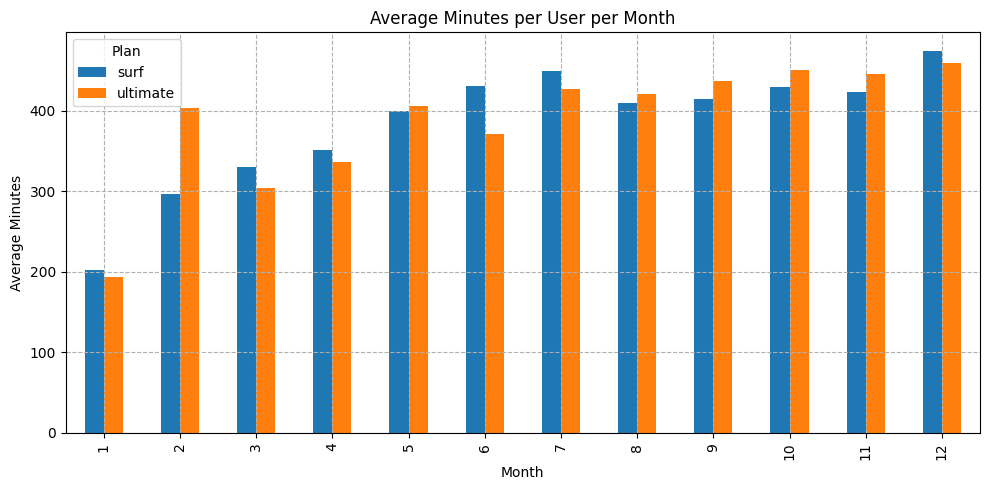

In [31]:
# Compare the average call duration for each plan and for each month.
calls_by_plan = full_user_monthly_data.groupby(['plan_name','month'])['total_minutes'].agg(['mean', 'var', 'std']).reset_index()

# Plot a bar chart to visualize it.
pivot_calls = calls_by_plan.pivot(index='month', columns='plan_name', values='mean')
pivot_calls.plot(kind='bar', figsize=(10,5), title='Average Minutes per User per Month')
plt.xlabel('Month')
plt.grid(True, linestyle='--')
plt.ylabel('Average Minutes')
plt.legend(title='Plan')
plt.tight_layout()
plt.show()

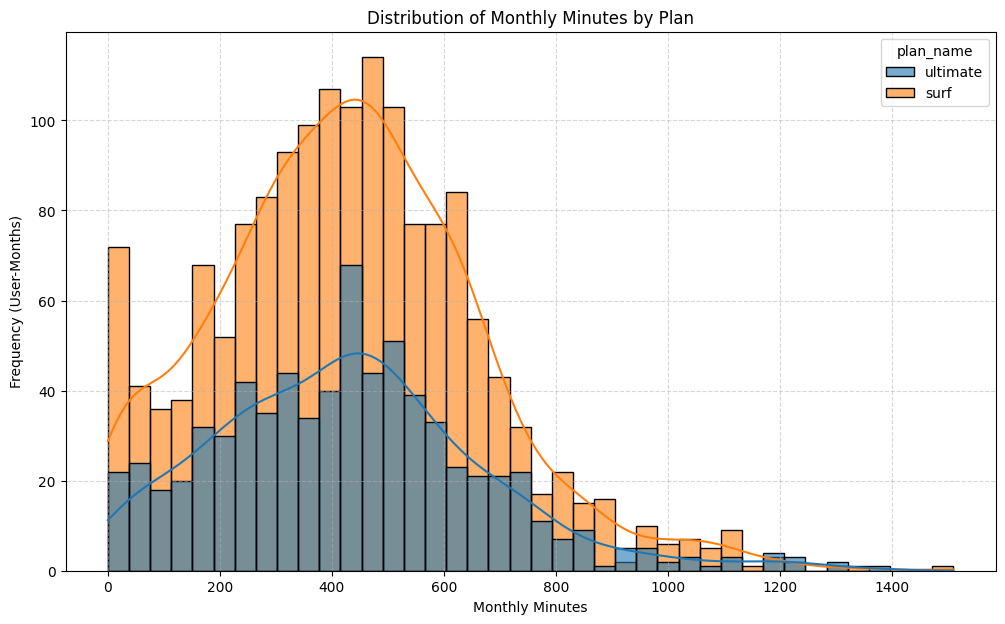

In [32]:
# Compare the number of monthly minutes required by users of each plan.
plt.figure(figsize=(12, 7))

sns.histplot(
    data=full_user_monthly_data,
    x='total_minutes',
    hue='plan_name',
    kde=True,
    alpha=0.6,
    bins=40
)

plt.title('Distribution of Monthly Minutes by Plan')
plt.xlabel('Monthly Minutes')
plt.ylabel('Frequency (User-Months)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [33]:
# Calculate the mean and variance of monthly call duration.
desc_calls = (full_user_monthly_data
              .groupby('plan_name')['total_minutes']
              .agg(['count','mean','median','var','std','min','max'])
              .round(2))
print(desc_calls)

           count    mean  median       var     std  min   max
plan_name                                                    
surf        1573  428.75   425.0  54968.28  234.45    0  1510
ultimate     720  430.45   424.0  57844.46  240.51    0  1369


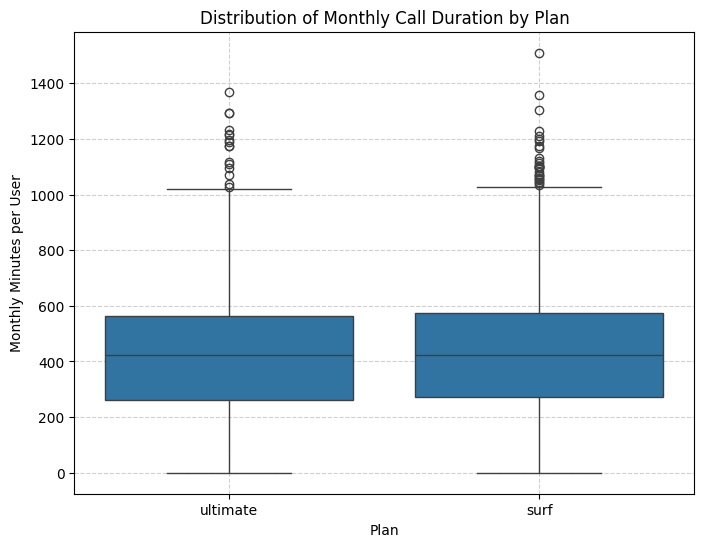

In [34]:
# Plot a boxplot to visualize the distribution of monthly call duration.
plt.figure(figsize=(8, 6))
sns.boxplot(data=full_user_monthly_data, x='plan_name', y='total_minutes')

plt.title('Distribution of Monthly Call Duration by Plan')
plt.xlabel('Plan')
plt.ylabel('Monthly Minutes per User')
plt.grid(True, linestyle='--', alpha=0.6)

# Display the plot
plt.show()

Regarding the variation between users and their plan type, there’s really no noticeable difference. Therefore, I can say that the difference is minimal.

### 2.4.2 Messages

In [35]:
# Compare the number of messages users of each plan tend to send each month
messages_desc = (full_user_monthly_data
                 .groupby('plan_name')['total_messages']
                 .agg(['count', 'mean', 'median', 'var', 'std', 'min', 'max'])
                 .round(2))

print("Descriptive statistics for monthly messages:")
print()
print(messages_desc)

Descriptive statistics for monthly messages:

           count   mean  median      var    std  min  max
plan_name                                                
surf        1573  31.16    24.0  1126.72  33.57    0  266
ultimate     720  37.55    30.0  1208.76  34.77    0  166


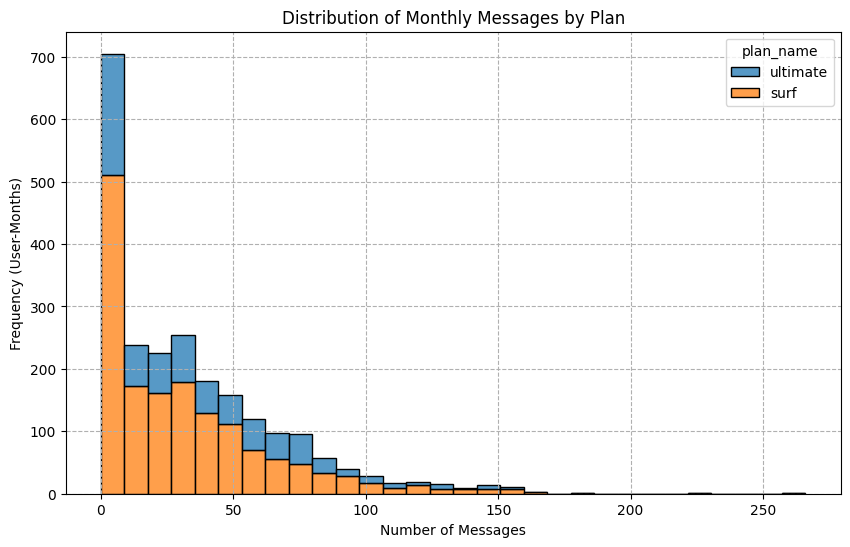

In [36]:
# Plot a bar chart to visualize it
plt.figure(figsize=(10, 6))
sns.histplot(data=full_user_monthly_data, x='total_messages', hue='plan_name', multiple='stack', bins=30)
plt.title('Distribution of Monthly Messages by Plan')
plt.xlabel('Number of Messages')
plt.ylabel('Frequency (User-Months)')
plt.grid(True, linestyle='--')
plt.show()

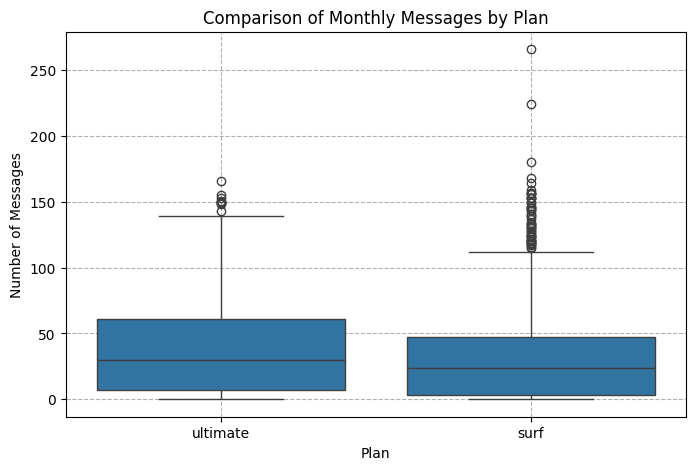

In [37]:
# Box plot for messages
plt.figure(figsize=(8, 5))
sns.boxplot(data=full_user_monthly_data, x='plan_name', y='total_messages')
plt.title('Comparison of Monthly Messages by Plan')
plt.xlabel('Plan')
plt.ylabel('Number of Messages')
plt.grid(True, linestyle='--')
plt.show()

My conclusion about the messages section is that, statistically, we can see that on average, users of the Ultimate plan send more messages than those on the Surf plan. <br>
As for the graphs, it can be observed that most users of both plans send fewer than 50 messages — which is the limit for the Surf plan — but for the Ultimate plan, very few users reach their 1,000-message limit.

### 2.4.3 Internet

In [38]:
internet_desc = (full_user_monthly_data
                 .groupby('plan_name')['total_data_gb']
                 .agg(['count', 'mean', 'median', 'var', 'std', 'min', 'max'])
                 .round(2))

print("Descriptive statistics for monthly GB consumption:")
print(internet_desc)

Descriptive statistics for monthly GB consumption:
           count   mean  median    var   std  min  max
plan_name                                             
surf        1573  16.67    17.0  61.58  7.85    0   70
ultimate     720  17.31    17.0  58.83  7.67    0   46


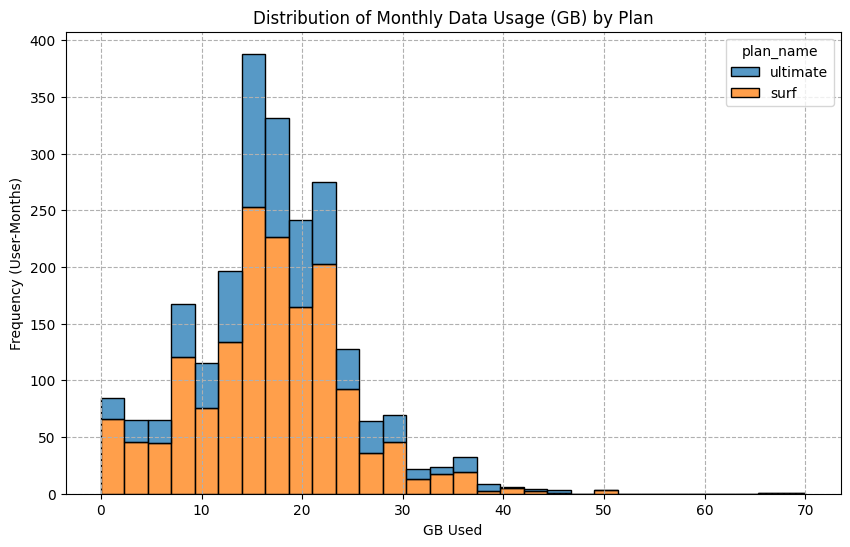

In [39]:
# Histogram for data usage
plt.figure(figsize=(10, 6))
sns.histplot(data=full_user_monthly_data, x='total_data_gb', hue='plan_name', multiple='stack', bins=30)
plt.title('Distribution of Monthly Data Usage (GB) by Plan')
plt.xlabel('GB Used')
plt.ylabel('Frequency (User-Months)')
plt.grid(True, linestyle='--')
plt.show()

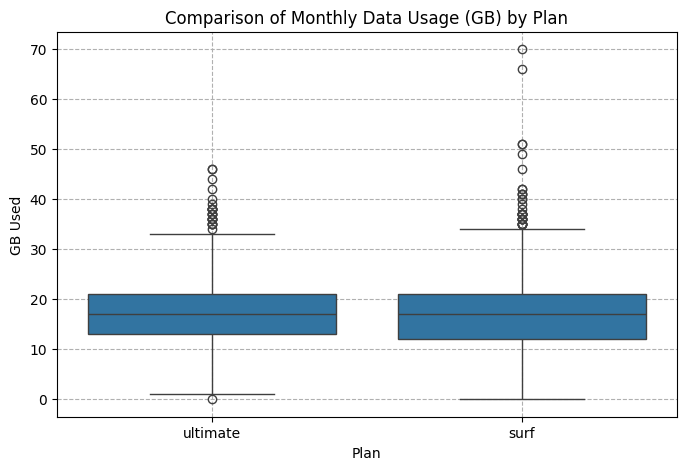

In [40]:
# Box plot for data usage
plt.figure(figsize=(8, 5))
sns.boxplot(data=full_user_monthly_data, x='plan_name', y='total_data_gb')
plt.title('Comparison of Monthly Data Usage (GB) by Plan')
plt.xlabel('Plan')
plt.ylabel('GB Used')
plt.grid(True, linestyle='--')
plt.show()

Regarding internet usage, we can see a greater variation (in proportion to their data limits) among users of both plans. <br>
In the case of Surf, users tend to exceed their included data limit more often, with some reaching up to 70GB. <br>
The users of both plans appear somewhat balanced overall, but considering their limits, it would be worth exploring why Surf customers tend to exceed their data allowance

### 2.4.4 Revenue

In [41]:
# Statistics by plan
revenue_desc = (full_user_monthly_data
                .groupby('plan_name')['monthly_revenue']
                .agg(['count','mean','median','var','std','min','max'])
                .round(2))
print(revenue_desc)

           count   mean  median      var    std   min     max
plan_name                                                    
surf        1573  60.71   40.36  3067.84  55.39  20.0  590.37
ultimate     720  72.31   70.00   129.85  11.40  70.0  182.00


In [42]:
# Separate data by plan
surf_data = full_user_monthly_data[full_user_monthly_data['plan_name'] == 'surf']
ultimate_data = full_user_monthly_data[full_user_monthly_data['plan_name'] == 'ultimate']

# Monthly average by plan
revenue_mean = (full_user_monthly_data
                .groupby(['plan_name','month'])['monthly_revenue']
                .mean()
                .reset_index())

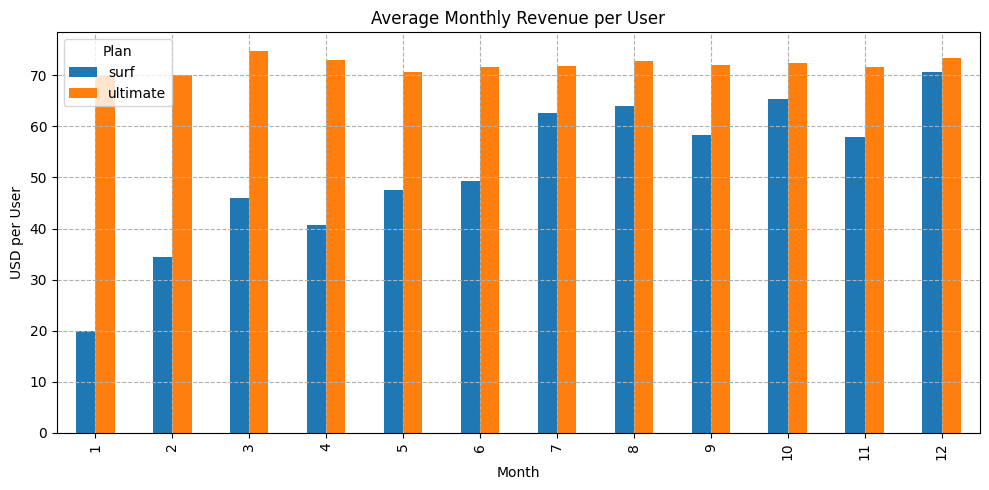

In [43]:
# Generate a bar chart to visually show the difference between plan types
pivot_rev = revenue_mean.pivot(index='month', columns='plan_name', values='monthly_revenue')
pivot_rev.plot(kind='bar', figsize=(10,5), title='Average Monthly Revenue per User')
plt.xlabel('Month')
plt.ylabel('USD per User')
plt.grid(True, linestyle='--')
plt.legend(title='Plan')
plt.tight_layout()
plt.show()

Based on the results of the chart, we could say that the average revenue for the “Ultimate” plan is higher than that of the “Surf” plan, with this difference observed across all months.

# 3. Test the statistical hypotheses

## 3.1 First hypothesis: 
- Null hypothesis (H₀): The average revenue of users on the Ultimate and Surf plans is equal.
- Alternative hypothesis (H₁): The average revenue of users on the Ultimate and Surf plans is different.
- Alpha value: 0.05

In [44]:
# Test the hypotheses
# Extract revenue by plan type
revenue_surf = surf_data['monthly_revenue']
revenue_ultimate = ultimate_data['monthly_revenue']
alpha = 0.05

results = st.ttest_ind(revenue_surf, revenue_ultimate, equal_var=False)
print("Hypothesis Test: Revenue for Ultimate and Surf Plans:")
print('p-value:', results.pvalue)
print()

if results.pvalue < alpha:
    print("We reject the null hypothesis: the average revenue of the plans is significantly different.")
else:
    print("We cannot reject the null hypothesis: there is not enough evidence to say that the average revenue is different.")

Hypothesis Test: Revenue for Ultimate and Surf Plans:
p-value: 3.170390548113574e-15

We reject the null hypothesis: the average revenue of the plans is significantly different.


Based on the results of this first hypothesis, we can reject the null hypothesis, which suggests that the average revenues of the two existing plans, “Surf” and “Ultimate,” are different.

## 3.2 Second Hypothesis

- Null hypothesis (H₀): The average revenue of users from NY-NJ is equal to that of users from other regions.
- Alternative hypothesis (H₁): The average revenue of users from NY-NJ is different from that of users from other regions.
- Alpha value: 0.05

In [45]:
# Test the hypotheses
ny_nj_users = full_user_monthly_data[full_user_monthly_data['city'].str.contains('NY-NJ', case=False)]
other_users = full_user_monthly_data[~full_user_monthly_data['city'].str.contains('NY-NJ', case=False)]

# Now, separate the revenues by group
revenue_ny_nj = ny_nj_users['monthly_revenue']
revenue_other = other_users['monthly_revenue']
alpha = 0.05

results_region = st.ttest_ind(revenue_ny_nj, revenue_other, equal_var=False)
print("Hypothesis Test: Revenue of NY-NJ Users vs. Other Regions:")
print('p-value:', results_region.pvalue)
print()

if results_region.pvalue < alpha:
    print("We reject the null hypothesis: the average revenue of NY-NJ users is significantly different from that of other regions.")
else:
    print("We cannot reject the null hypothesis: there is not enough evidence to say that the average revenue is different.")

Hypothesis Test: Revenue of NY-NJ Users vs. Other Regions:
p-value: 0.0335256158853001

We reject the null hypothesis: the average revenue of NY-NJ users is significantly different from that of other regions.


Based on the results of this second hypothesis, we can reject the null hypothesis, suggesting that the revenues from the NY-NJ region are significantly different from those of other regions.

# 4. General conclusion

The goal of this project was to determine which of the two prepaid plans, Surf or Ultimate, generates higher average revenue per customer for the telecom operator Megaline, in order to guide the advertising budget.

- We began with data preprocessing:

A thorough cleaning and transformation were carried out on data from five different sources (users, calls, messages, internet, and plans).
Key tasks included correcting data types, handling missing values, converting MB to GB, and applying Megaline’s rounding rules for call minutes and monthly data usage.
Consumption data (minutes, messages, GB) were aggregated per user and per month.
Finally, monthly revenue was calculated for each user, considering both the base plan rate and extra charges for exceeding included limits.

- User Behavior Analysis

The behavioral analysis showed that Surf plan users exceed their limits (especially data) much more frequently than Ultimate plan users, resulting in variable but sometimes significant extra-charge revenues.
Ultimate plan users, with higher included limits, rarely incur additional charges, providing more predictable and higher base-rate revenue.
Despite occasional revenue spikes from overages in the Surf plan, the average monthly revenue per user was consistently higher for the Ultimate plan.

- Hypothesis Testing

A Student’s t-test confirmed that the difference in average monthly revenue between the Surf and Ultimate plans is statistically significant.
There was also a statistically significant difference between the average revenues generated by users in the NY-NJ region and those in other regions.

- Final Insight

Although the Surf plan can sometimes generate high individual revenues when users exceed their limits, the Ultimate plan proves to be, on average, more profitable per customer for Megaline.
This finding suggests that the marketing department could focus part of its advertising budget on attracting or retaining Ultimate plan customers, given their higher and more stable contribution to average revenue.